In [1]:
import pandas as pd
import numpy as np
import os
from scipy.ndimage import rotate
import scipy.ndimage
from joblib import Parallel, delayed
import multiprocessing
import itertools
import pydicom
import SimpleITK as sitk
from scipy.ndimage import zoom 
from sklearn.model_selection import train_test_split

#Code from existing github repo provided by UC Irvine dataset
from utils.equalizer import histEq
from utils.utils import cutCube

In [2]:
# Modified DICOM loading functions for newer pydicom versions
def load_scan(path2scan):
    if (path2scan.split('.')[-1] == 'mhd') or (path2scan.split('.')[-1] == 'raw'):
        return load_mhd(path2scan)
    elif path2scan.split('.')[-1] == 'dcm':
        return load_dicom(os.path.split(path2scan)[0]) #pass containing directory
    elif os.path.isdir(path2scan) and any(f.endswith('.dcm') for f in os.listdir(path2scan)):
        return load_dicom(path2scan)
    else:
        raise Exception('No valid scan [series] found in given file/directory')

def load_mhd(path2scan):
    itkimage = sitk.ReadImage(path2scan)
    scan = sitk.GetArrayFromImage(itkimage)
    spacing = np.flip(np.array(itkimage.GetSpacing()),axis=0)
    orientation = np.transpose(np.array(itkimage.GetDirection()).reshape((3, 3)))
    origin = np.flip(np.array(itkimage.GetOrigin()),axis=0)
    return scan, spacing, orientation, origin, None

def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
    if not dcms:
        raise Exception(f"No DICOM files found in {dicom_folder}")
    
    first_slice_data = pydicom.dcmread(os.path.join(path2scan_dir, dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient)
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]])

    scan = np.zeros((len(dcms), first_slice.shape[0], first_slice.shape[1]))
    raw_slices = []
    indexes = []
    
    for dcm in dcms:
        slice_data = pydicom.dcmread(os.path.join(dicom_folder, dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    
    indexes = np.array(indexes, dtype=float)
    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    
    try:
        origin = np.array(raw_slices[0][0x00200032].value)
        origin = np.array([origin[2], origin[1], origin[0]])
    except:
        origin = np.zeros(3)

    for i, slice_obj in enumerate(raw_slices):
        scan[i, :, :] = slice_obj.pixel_array
    
    return scan, spacing, orientation, origin, raw_slices

def scale_scan(scan, spacing, factor=1):
    resize_factor = factor * spacing
    new_real_shape = scan.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / scan.shape
    new_spacing = spacing / real_resize_factor
    scan_resized = scipy.ndimage.zoom(scan, real_resize_factor, mode='nearest')
    return scan_resized, resize_factor

def get_scaled_shape(shape, spacing):
    new_real_shape = shape * spacing
    return np.round(new_real_shape).astype(int)

def world2vox(world_coord, spacing, orientation, origin):
    world_coord = np.dot(np.linalg.inv(np.dot(orientation, np.diag(spacing))), world_coord - origin)
    if orientation[0, 0] < 0:
        vox_coord = (np.array([world_coord[0], world_coord[2], world_coord[1]])).astype(int)
    else:
        vox_coord = (np.array([world_coord[0], world_coord[1], world_coord[2]])).astype(int)
    return vox_coord

In [3]:
class CombinedLabeledExtractor:
    """
    Extractor that combines multiple experiments into one dataset
    Modified to split data BEFORE augmentation
    """
    def __init__(self, 
                 experiments_config,  
                 dst_path, 
                 norm_save_dir,
                 cube_shape=(32, 32, 32),
                 parallelize=False,
                 coordSystem='vox',
                 include_types=['FB', 'FM', 'TM'], 
                 augment=True,
                 train_ratio=0.6,
                 val_ratio=0.2,
                 test_ratio=0.2,
                 random_state=42):
        """
        Args:
            experiments_config: List of experiment configurations
            dst_path: Where to save the combined processed dataset
            norm_save_dir: Where to save normalization parameters
            cube_shape: Size of extracted 3D cubes
            parallelize: Whether to use multiprocessing
            coordSystem: 'vox' for voxel coordinates
            include_types: Which finding types to include
            augment: Whether to perform data augmentation (only on training set)
            train_ratio: Proportion of data for training
            val_ratio: Proportion of data for validation
            test_ratio: Proportion of data for testing
            random_state: Random seed for reproducibility
        """
        self.experiments_config = experiments_config
        self.dst_path = dst_path
        self.norm_save_dir = norm_save_dir
        self.cube_shape = cube_shape
        self.parallelize = parallelize
        self.coordSystem = coordSystem
        self.include_types = include_types
        self.augment = augment
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state
        
        # Load and combine labels from all experiments
        self.combined_labels_df = pd.DataFrame()
        
        for exp_config in experiments_config:
            print(f"\nLoading labels for {exp_config['experiment_name']}...")
            
            # Load labels for this experiment
            labels_df = pd.read_csv(exp_config['labels_csv'])
            
            # Add experiment identifier
            labels_df['experiment'] = exp_config['experiment_name']
            labels_df['dicom_base_dir'] = exp_config['dicom_dir']
            
            # Filter by type
            labels_df = labels_df[labels_df['type'].isin(include_types)]
            
            # Filter out TB entries with 0,0,0 coordinates
            labels_df = labels_df[~((labels_df['type'] == 'TB') & 
                                   (labels_df['x'] == 0) & 
                                   (labels_df['y'] == 0) & 
                                   (labels_df['slice'] == 0))]
            
            print(f"Loaded {len(labels_df)} samples from {exp_config['experiment_name']}")
            print(f"Types distribution:\n{labels_df['type'].value_counts()}")
            
            # Combine with existing labels
            self.combined_labels_df = pd.concat([self.combined_labels_df, labels_df], 
                                                ignore_index=True)
        
        print(f"\nTotal combined samples: {len(self.combined_labels_df)}")
        print(f"Combined types distribution:\n{self.combined_labels_df['type'].value_counts()}")
        print(f"Samples per experiment:\n{self.combined_labels_df['experiment'].value_counts()}")

    def extract(self, plot=True):
        """Extract and process all labeled samples from all experiments"""
        print("\nPreparing extraction jobs for combined dataset...")
        
        # create train/val/test split on the original data
        train_df, val_df, test_df = self._create_data_splits()
        
        # Process each split separately
        splits_data = {}
        
        for split_name, split_df, apply_augment in [
            ('train', train_df, self.augment),
            ('val', val_df, False),
            ('test', test_df, False)
        ]:
            print(f"\n{'='*50}")
            print(f"Processing {split_name} set ({len(split_df)} samples)...")
            print(f"Augmentation: {'ON' if apply_augment else 'OFF'}")
            
            instances, labels, experiments = self._process_split(split_df, apply_augment)
            
            if len(instances) == 0:
                print(f"ERROR: No instances were successfully extracted for {split_name}!")
                continue
            
            splits_data[split_name] = {
                'instances': instances,
                'labels': labels,
                'experiments': experiments
            }
            
            print(f"Successfully extracted {len(instances)} instances for {split_name}")
        
        # Combine all splits for normalization (but keep track of indices)
        all_instances = []
        split_indices = {}
        current_idx = 0
        
        for split_name in ['train', 'val', 'test']:
            if split_name in splits_data:
                split_size = len(splits_data[split_name]['instances'])
                split_indices[split_name] = (current_idx, current_idx + split_size)
                all_instances.extend(splits_data[split_name]['instances'])
                current_idx += split_size
        
        all_instances = np.array(all_instances)
        
        # Preprocessing on all data
        print("\n\nEqualizing the data across all splits...")
        from utils.equalizer import histEq
        eq = histEq(all_instances)
        all_instances = eq.equalize(all_instances)
        os.makedirs(self.norm_save_dir, exist_ok=True)
        eq.save(path=os.path.join(self.norm_save_dir, 'equalization.pkl'))

        print("Normalizing the data...")
        min_v = np.min(all_instances)
        max_v = np.max(all_instances)
        mean_v = np.mean(all_instances)
        norm_data = np.array([mean_v, min_v, max_v])
        all_instances = (all_instances - mean_v) / (max_v - min_v)
        np.save(os.path.join(self.norm_save_dir, 'normalization.npy'), norm_data)
        
        # Split back the normalized data
        for split_name, (start_idx, end_idx) in split_indices.items():
            splits_data[split_name]['instances'] = all_instances[start_idx:end_idx]
        
        # Save each split separately
        print("\n\nSaving the split datasets...")
        
        for split_name in ['train', 'val', 'test']:
            if split_name in splits_data:
                split_path = self.dst_path.replace('.npy', f'_{split_name}.npy')
                np.save(split_path, splits_data[split_name]['instances'])
                np.save(split_path.replace('.npy', '_labels.npy'), splits_data[split_name]['labels'])
                np.save(split_path.replace('.npy', '_experiments.npy'), splits_data[split_name]['experiments'])
                
                print(f"Saved {split_name} set: {len(splits_data[split_name]['instances'])} samples")
        
        # Save metadata
        metadata = {
            'label_mapping': {label: int(idx) for idx, label in enumerate(np.unique(self.combined_labels_df['type']))},
            'experiment_info': {exp: int(idx) for idx, exp in enumerate(np.unique(self.combined_labels_df['experiment']))},
            'split_sizes': {
                split_name: len(splits_data[split_name]['instances']) 
                for split_name in splits_data
            },
            'split_ratios': {
                'train': self.train_ratio,
                'val': self.val_ratio,
                'test': self.test_ratio
            },
            'augmentation_applied': {
                'train': self.augment,
                'val': False,
                'test': False
            },
            'random_state': self.random_state
        }
        
        import json
        with open(self.dst_path.replace('.npy', '_metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"\nLabel mapping: {metadata['label_mapping']}")
        print(f"Experiment mapping: {metadata['experiment_info']}")
        print(f"\nFinal split sizes:")
        for split_name, size in metadata['split_sizes'].items():
            print(f"  {split_name}: {size} samples")
        
        if plot:
            self._plot_split_distributions(splits_data)
        
        return splits_data, metadata

    def _create_data_splits(self):
        """Create train/val/test splits with stratification"""
        print("\nCreating train/val/test splits...")
        
        # Create stratification key combining type and experiment
        self.combined_labels_df['stratify_key'] = (
            self.combined_labels_df['type'] + '_' + 
            self.combined_labels_df['experiment']
        )
        
        # First split: train+val vs test
        train_val_df, test_df = train_test_split(
            self.combined_labels_df,
            test_size=self.test_ratio,
            stratify=self.combined_labels_df['stratify_key'],
            random_state=self.random_state
        )
        
        # Second split: train vs val
        val_size_adjusted = self.val_ratio / (self.train_ratio + self.val_ratio)
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=val_size_adjusted,
            stratify=train_val_df['stratify_key'],
            random_state=self.random_state
        )
        
        print(f"Split sizes:")
        print(f"  Train: {len(train_df)} samples ({len(train_df)/len(self.combined_labels_df)*100:.1f}%)")
        print(f"  Val: {len(val_df)} samples ({len(val_df)/len(self.combined_labels_df)*100:.1f}%)")
        print(f"  Test: {len(test_df)} samples ({len(test_df)/len(self.combined_labels_df)*100:.1f}%)")
        
        # Print distribution per split
        for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
            print(f"\n{split_name} set distribution:")
            print(split_df['type'].value_counts())
        
        return train_df, val_df, test_df

    def _process_split(self, split_df, apply_augment):
        """Process a single data split"""
        jobs = []
        labels = []
        experiments = []
        
        for idx, row in split_df.iterrows():
            # Build path to DICOM scan
            scan_path = os.path.join(row['dicom_base_dir'], str(row['uuid']))
            scan_path = os.path.normpath(scan_path)
            
            # Coordinate in z,y,x format
            coord = np.array([row['slice'], row['y'], row['x']])
            
            # Job format: [scan_path, coord, cube_shape, coordSystem, label_type, apply_augment]
            jobs.append([scan_path, coord, self.cube_shape, self.coordSystem, row['type'], apply_augment])
            labels.append(row['type'])
            experiments.append(row['experiment'])
        
        print(f"Extracting {len(jobs)} samples...")
        
        if self.parallelize:
            num_cores = int(np.ceil(min(np.ceil(multiprocessing.cpu_count() * 0.75), len(jobs))))
            results = Parallel(n_jobs=num_cores)(delayed(self._process_job)(job) for job in jobs)
        else:
            results = []
            for i, job in enumerate(jobs):
                try:
                    result = self._process_job(job)
                    results.append(result)
                    if i % 10 == 0:
                        print(f"Processed {i+1}/{len(jobs)} samples")
                except Exception as e:
                    print(f"Failed to process sample {job[0]}: {e}")
                    results.append(None)
        
        # Collect successful extractions
        instances = []
        instance_labels = []
        instance_experiments = []
        
        for i, result in enumerate(results):
            if result is not None:
                cubes, label_type = result
                instances.extend(cubes)
                instance_labels.extend([label_type] * len(cubes))
                instance_experiments.extend([experiments[i]] * len(cubes))
        
        return np.array(instances), np.array(instance_labels), np.array(instance_experiments)

    def _process_job(self, args):
        """Process single extraction job"""
        scan_path, coord, cube_shape, coordSystem, label_type, apply_augment = args
        
        try:
            # Load scan
            scan, spacing, orientation, origin, raw_slices = load_scan(scan_path)
            
            # Convert coordinates if needed
            if coordSystem == 'world':
                coord = world2vox(coord, spacing, orientation, origin)
            
            # Extract the base cube with padding
            from utils.utils import cutCube
            init_cube_shape = get_scaled_shape(np.array(cube_shape) + 8, 1/spacing)
            clean_cube_unscaled = cutCube(scan, coord, init_cube_shape, padd=-1000)
            
            # Scale the cube
            scaled_cube, resize_factor = scale_scan(clean_cube_unscaled, spacing)
            
            # Data augmentation (only if specified)
            if apply_augment:
                augmented_cubes = self._augment_instance(scaled_cube)
            else:
                augmented_cubes = [scaled_cube]
            
            # Trim to final shape
            final_cubes = []
            for cube in augmented_cubes:
                center = np.array(cube.shape) // 2
                final_cube = cutCube(cube, center, cube_shape, padd=-1000)
                if final_cube.shape == tuple(cube_shape):
                    final_cubes.append(final_cube)
            
            return final_cubes, label_type
            
        except Exception as e:
            print(f"Error processing {scan_path}: {e}")
            return None

    def _augment_instance(self, x0):
        """Data augmentation"""
        augmented = [x0]  # Original
        
        # Flips
        augmented.append(np.flip(x0, 1))  # x flip
        augmented.append(np.flip(x0, 2))  # y flip
        
        # Small shifts
        augmented.append(scipy.ndimage.shift(x0, (0, 2, 2), mode='constant'))
        augmented.append(scipy.ndimage.shift(x0, (0, -2, 2), mode='constant'))
        
        # Small rotations
        for angle in [15, 30, 45, 90, 180]:
            rotated = rotate(x0, angle, axes=(1, 2), mode='reflect', reshape=False)
            augmented.append(rotated)
        
        # Filter out invalid shapes
        valid_cubes = []
        for cube in augmented:
            if cube.shape[0] > 0 and cube.shape[1] > 0 and cube.shape[2] > 0:
                valid_cubes.append(cube)
        
        return valid_cubes

    def _plot_split_distributions(self, splits_data):
        """Plot distributions for each split"""
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Sample counts per split
        split_names = list(splits_data.keys())
        split_sizes = [len(splits_data[s]['instances']) for s in split_names]
        
        axes[0, 0].bar(split_names, split_sizes, color=['#2E86AB', '#A23B72', '#F18F01'])
        axes[0, 0].set_title('Sample Count per Split', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Number of Samples')
        
        for i, (name, size) in enumerate(zip(split_names, split_sizes)):
            axes[0, 0].text(i, size + 10, str(size), ha='center', fontweight='bold')
        
        # Plot 2: Type distribution per split
        width = 0.25
        x = np.arange(len(split_names))
        
        unique_types = ['FB', 'FM', 'TM']
        colors = {'FB': '#FF6B6B', 'FM': '#4ECDC4', 'TM': '#45B7D1'}
        
        for i, ttype in enumerate(unique_types):
            counts = []
            for split_name in split_names:
                type_count = np.sum(splits_data[split_name]['labels'] == ttype)
                counts.append(type_count)
            
            axes[0, 1].bar(x + i*width, counts, width, label=ttype, color=colors[ttype])
        
        axes[0, 1].set_xlabel('Split')
        axes[0, 1].set_ylabel('Number of Samples')
        axes[0, 1].set_title('Type Distribution per Split', fontsize=14, fontweight='bold')
        axes[0, 1].set_xticks(x + width)
        axes[0, 1].set_xticklabels(split_names)
        axes[0, 1].legend()
        
        # Plot 3: Experiment distribution per split
        unique_experiments = ['Experiment_1', 'Experiment_2']
        exp_colors = ['#8B5A3C', '#6B8E23']
        
        for i, exp in enumerate(unique_experiments):
            counts = []
            for split_name in split_names:
                exp_count = np.sum(splits_data[split_name]['experiments'] == exp)
                counts.append(exp_count)
            
            axes[1, 0].bar(x + i*width*1.5, counts, width*1.5, label=exp, color=exp_colors[i])
        
        axes[1, 0].set_xlabel('Split')
        axes[1, 0].set_ylabel('Number of Samples')
        axes[1, 0].set_title('Experiment Distribution per Split', fontsize=14, fontweight='bold')
        axes[1, 0].set_xticks(x + width*0.75)
        axes[1, 0].set_xticklabels(split_names)
        axes[1, 0].legend()
        
        # Plot 4: Augmentation effect (for training set)
        if 'train' in splits_data:
            train_labels = splits_data['train']['labels']
            unique_labels, counts = np.unique(train_labels, return_counts=True)
            
            # Estimate original counts (before augmentation)
            # This is approximate based on the augmentation factor
            original_train_size = len(self.combined_labels_df) * self.train_ratio
            augmentation_factor = len(train_labels) / original_train_size
            
            axes[1, 1].text(0.5, 0.5, f'Training Set Augmentation\n\nOriginal: ~{int(original_train_size)} samples\n'
                           f'After Augmentation: {len(train_labels)} samples\n'
                           f'Augmentation Factor: ~{augmentation_factor:.1f}x',
                           ha='center', va='center', fontsize=12,
                           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
            axes[1, 1].set_title('Augmentation Summary', fontsize=14, fontweight='bold')
            axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.suptitle('Data Split Analysis', fontsize=16, fontweight='bold', y=1.02)
        plt.show()


In [4]:
class CombinedDataLoader:
    """
    Data loader for combined dataset with split support
    """
    def __init__(self, dataset_base_path, normdata_path, img_res=(32, 32, 32)):
        self.dataset_base_path = dataset_base_path
        self.normdata_path = normdata_path
        self.img_res = img_res
        self.splits = {}
        
        # Load metadata
        import json
        metadata_path = dataset_base_path.replace('.npy', '_metadata.json')
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Load each split
        for split in ['train', 'val', 'test']:
            split_path = dataset_base_path.replace('.npy', f'_{split}.npy')
            if os.path.exists(split_path):
                print(f"\nLoading {split} set...")
                
                data = np.load(split_path)
                labels = np.load(split_path.replace('.npy', '_labels.npy'))
                experiments = np.load(split_path.replace('.npy', '_experiments.npy'))
                
                # Format for neural network
                data = data.reshape((len(data), self.img_res[0], self.img_res[1], self.img_res[2], 1))
                
                # Convert labels to indices
                label_to_idx = self.metadata['label_mapping']
                label_indices = np.array([label_to_idx[label] for label in labels])
                
                self.splits[split] = {
                    'data': data,
                    'labels': labels,
                    'label_indices': label_indices,
                    'experiments': experiments
                }
                
                print(f"Loaded {len(data)} samples for {split}")
                print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")
    
    def get_split(self, split_name):
        """Get a specific split"""
        if split_name not in self.splits:
            raise ValueError(f"Split '{split_name}' not found. Available splits: {list(self.splits.keys())}")
        return self.splits[split_name]
    
    def load_batch(self, split_name='train', batch_size=32, shuffle=True):
        """Load batches from a specific split"""
        if split_name not in self.splits:
            raise ValueError(f"Split '{split_name}' not found")
        
        split_data = self.splits[split_name]
        data = split_data['data']
        labels = split_data['label_indices']
        
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)
        
        n_batches = len(indices) // batch_size
        
        for i in range(n_batches):
            batch_indices = indices[i * batch_size:(i + 1) * batch_size]
            batch_data = data[batch_indices]
            batch_labels = labels[batch_indices]
            
            yield batch_data, batch_labels


Loading labels for Experiment_1...
Loaded 118 samples from Experiment_1
Types distribution:
type
FB    61
FM    34
TM    23
Name: count, dtype: int64

Loading labels for Experiment_2...
Loaded 30 samples from Experiment_2
Types distribution:
type
TM    12
FB    11
FM     7
Name: count, dtype: int64

Total combined samples: 148
Combined types distribution:
type
FB    72
FM    41
TM    35
Name: count, dtype: int64
Samples per experiment:
experiment
Experiment_1    118
Experiment_2     30
Name: count, dtype: int64

Preparing extraction jobs for combined dataset...

Creating train/val/test splits...
Split sizes:
  Train: 88 samples (59.5%)
  Val: 30 samples (20.3%)
  Test: 30 samples (20.3%)

Train set distribution:
type
FB    44
FM    24
TM    20
Name: count, dtype: int64

Val set distribution:
type
FB    14
FM     9
TM     7
Name: count, dtype: int64

Test set distribution:
type
FB    14
TM     8
FM     8
Name: count, dtype: int64

Processing train set (88 samples)...
Augmentation: ON
E

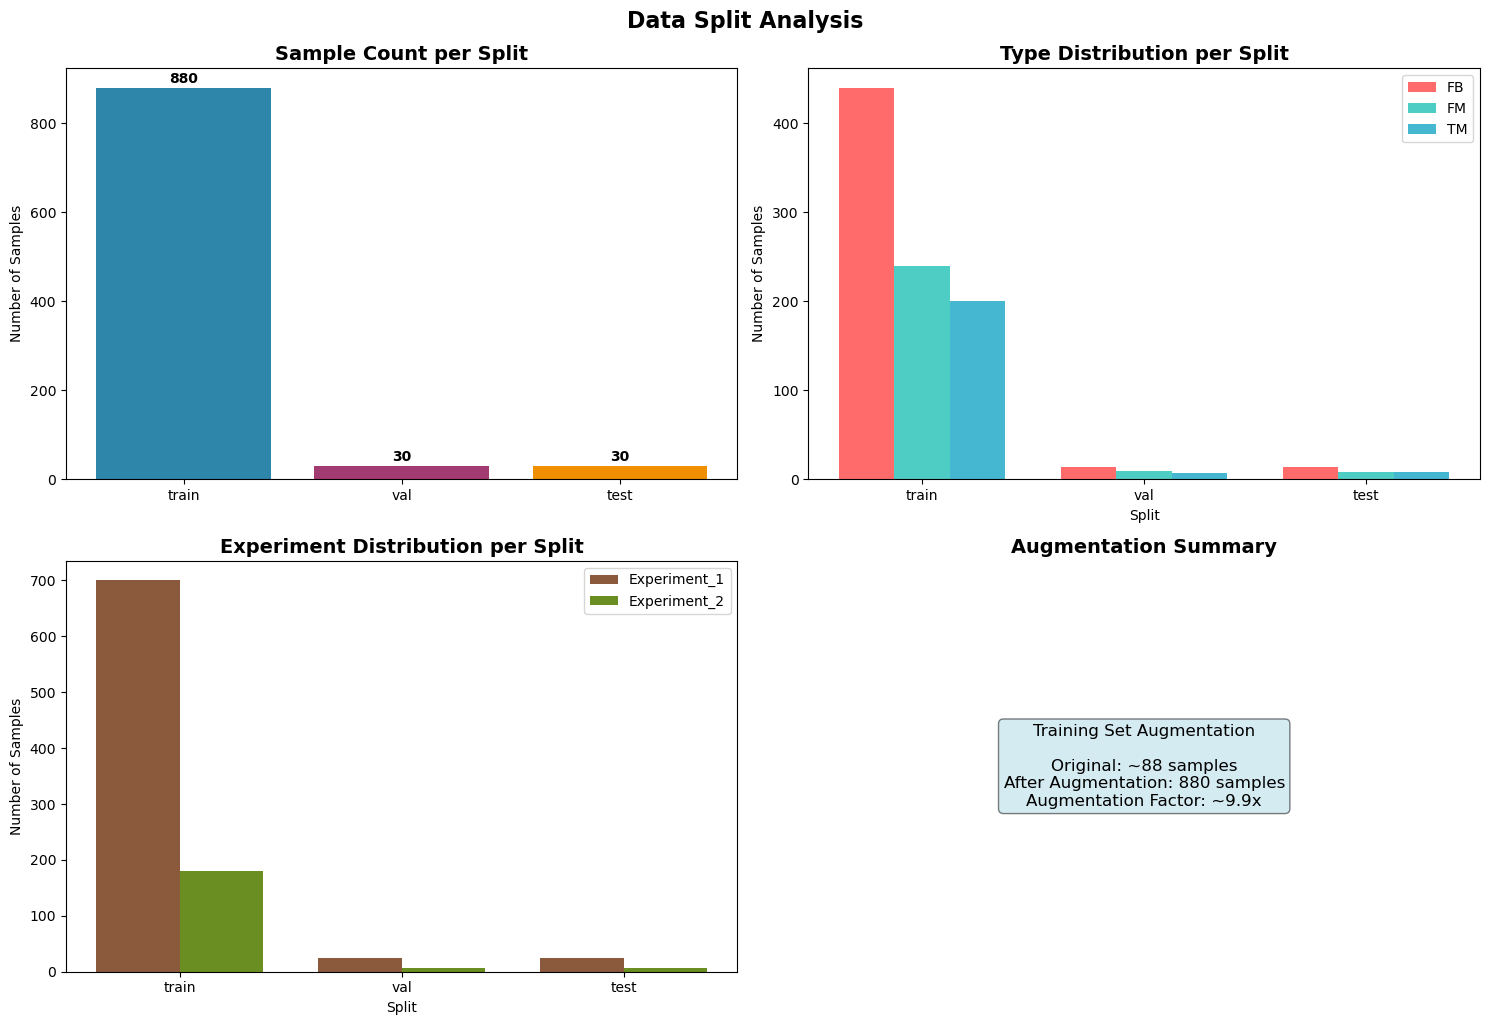


Loading train set...
Loaded 880 samples for train
Label distribution: {'FB': 440, 'FM': 240, 'TM': 200}

Loading val set...
Loaded 30 samples for val
Label distribution: {'FB': 14, 'FM': 9, 'TM': 7}

Loading test set...
Loaded 30 samples for test
Label distribution: {'FB': 14, 'FM': 8, 'TM': 8}


Example: Loading training batches...
Batch 1: (32, 32, 32, 32, 1), Labels: [1 0 0 0 0 0 2 0 0 2 0 2 2 2 1 1 2 0 0 0 2 0 1 0 1 2 0 0 0 0 0 1]
Batch 2: (32, 32, 32, 32, 1), Labels: [1 0 0 0 0 0 0 0 1 2 0 0 2 2 1 1 0 0 2 0 0 2 0 2 2 1 1 0 0 2 0 0]
Batch 3: (32, 32, 32, 32, 1), Labels: [1 2 0 1 1 2 0 0 1 0 1 0 0 1 0 0 0 2 0 1 0 1 2 0 1 1 2 0 0 1 1 0]


In [5]:
if __name__ == "__main__":
    # Configuration for combined dataset
    base_path = os.path.expanduser("~/Downloads/deepfakes+medical+image+tamper+detection (1)/data/Tampered Scans/")
    
    # Define experiments configuration
    experiments_config = [
        {
            'labels_csv': os.path.join(base_path, "labels_exp1.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 1 - Blind"),
            'experiment_name': 'Experiment_1'
        },
        {
            'labels_csv': os.path.join(base_path, "labels_exp2.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 2 - Open"),
            'experiment_name': 'Experiment_2'
        }
    ]
    
    output_dataset = "combined_tampered_scans_dataset.npy"
    normalization_dir = "combined_tampered_scans_normalization"
    
    # Extract and preprocess combined dataset with split-first approach
    extractor = CombinedLabeledExtractor(
        experiments_config=experiments_config,
        dst_path=output_dataset,
        norm_save_dir=normalization_dir,
        cube_shape=(32, 32, 32),
        include_types=['FB', 'FM', 'TM'], 
        augment=True,  # Will only be applied to training set
        parallelize=False,
        train_ratio=0.6,
        val_ratio=0.2,
        test_ratio=0.2,
        random_state=42
    )
    
    splits_data, metadata = extractor.extract()
    
    # Load the split datasets
    if splits_data is not None:
        dataloader = CombinedDataLoader(
            dataset_base_path=output_dataset,
            normdata_path=normalization_dir
        )
        
        # Example: iterate through training batches
        print("\n\nExample: Loading training batches...")
        for i, (batch_data, batch_labels) in enumerate(dataloader.load_batch('train', batch_size=32)):
            print(f"Batch {i+1}: {batch_data.shape}, Labels: {batch_labels}")
            if i >= 2:  # Just show first 3 batches
                break

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import json

def create_combined_eda_dataframe(experiments_config, processed_data_path=None, 
                                 processed_labels_path=None, processed_experiments_path=None,
                                 metadata_path=None):
    """
    Create dataframe for EDA from combined experiments
    """
    # Load and combine labels from all experiments
    combined_df = pd.DataFrame()
    
    for exp_config in experiments_config:
        print(f"\nLoading labels for {exp_config['experiment_name']}...")
        
        # Load labels for this experiment
        df_exp = pd.read_csv(exp_config['labels_csv'])
        df_exp['experiment'] = exp_config['experiment_name']
        
        # Filter types
        df_exp = df_exp[df_exp['type'].isin(['FB', 'FM', 'TM'])]
        df_exp = df_exp[~((df_exp['type'] == 'TB') & 
                         (df_exp['x'] == 0) & 
                         (df_exp['y'] == 0) & 
                         (df_exp['slice'] == 0))]
        
        print(f"  {exp_config['experiment_name']}: {len(df_exp)} instances after filtering")
        
        combined_df = pd.concat([combined_df, df_exp], ignore_index=True)
    
    print(f"\nTotal combined instances: {len(combined_df)}")
    
    # Add encoded labels
    le = LabelEncoder()
    combined_df['type_encoded'] = le.fit_transform(combined_df['type'])
    
    # Add augmentation info if processed data available
    if processed_data_path and processed_labels_path:
        try:
            processed_labels = np.load(processed_labels_path)
            if processed_experiments_path:
                processed_experiments = np.load(processed_experiments_path)
            
            print(f"Processed dataset size: {len(processed_labels)}")
            
            # Calculate overall augmentation factor
            augmentation_factor = len(processed_labels) / len(combined_df)
            combined_df['augmentation_factor'] = augmentation_factor
            
            # Load metadata if available
            if metadata_path:
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                    combined_df['metadata'] = str(metadata)
            
        except FileNotFoundError:
            print("Processed data not found, using original data only")
            combined_df['augmentation_factor'] = 1
    
    return combined_df, le

def plot_combined_class_distribution(df):
    """Create class distribution bar plot with experiment breakdown"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Overall distribution
    class_counts = df['type'].value_counts()
    classes = class_counts.index
    counts = class_counts.values
    
    colors = {'FB': '#FF6B6B', 'FM': '#4ECDC4', 'TM': '#45B7D1'}
    plot_colors = [colors[cls] for cls in classes]
    
    # Plot 1: Overall distribution
    bars = axes[0].bar(classes, counts, color=plot_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    axes[0].set_title('Overall Distribution of Tamper Types', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Tamper Classification', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
    
    # Add value labels
    for bar, count in zip(bars, counts):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Add percentage labels
    total = sum(counts)
    for bar, count in zip(bars, counts):
        percentage = (count/total) * 100
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                    f'{percentage:.1f}%', ha='center', va='center', 
                    fontweight='bold', fontsize=10, color='white')
    
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Distribution by experiment
    exp_type_counts = df.groupby(['experiment', 'type']).size().unstack(fill_value=0)
    
    x = np.arange(len(exp_type_counts.index))
    width = 0.25
    
    for i, tamper_type in enumerate(['FB', 'FM', 'TM']):
        if tamper_type in exp_type_counts.columns:
            values = exp_type_counts[tamper_type]
            axes[1].bar(x + i*width, values, width, label=tamper_type, 
                       color=colors[tamper_type], alpha=0.8, edgecolor='black')
            
            # Add value labels
            for j, v in enumerate(values):
                if v > 0:
                    axes[1].text(j + i*width, v + 0.5, str(v), 
                               ha='center', va='bottom', fontsize=9)
    
    axes[1].set_xlabel('Experiment', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution by Experiment', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x + width)
    axes[1].set_xticklabels(exp_type_counts.index)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n=== Combined Dataset Statistics ===")
    print(f"Total instances: {len(df)}")
    print(f"\nOverall class distribution:")
    for cls in classes:
        count = class_counts[cls]
        pct = (count/total) * 100
        print(f"  {cls}: {count} instances ({pct:.1f}%)")
    
    print(f"\nDistribution by experiment:")
    for exp in df['experiment'].unique():
        exp_df = df[df['experiment'] == exp]
        print(f"\n{exp} ({len(exp_df)} total):")
        exp_counts = exp_df['type'].value_counts()
        for cls, count in exp_counts.items():
            pct = (count/len(exp_df)) * 100
            print(f"  {cls}: {count} ({pct:.1f}%)")

def plot_experiment_comparison(df):
    """Compare characteristics between experiments"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    experiments = df['experiment'].unique()
    
    # 1. Spatial distribution comparison - X coordinate
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        axes[0, 0].hist(exp_data['x'], bins=20, alpha=0.6, label=exp, density=True)
    axes[0, 0].set_xlabel('X Coordinate', fontweight='bold')
    axes[0, 0].set_ylabel('Density', fontweight='bold')
    axes[0, 0].set_title('X Coordinate Distribution by Experiment', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Y coordinate
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        axes[0, 1].hist(exp_data['y'], bins=20, alpha=0.6, label=exp, density=True)
    axes[0, 1].set_xlabel('Y Coordinate', fontweight='bold')
    axes[0, 1].set_ylabel('Density', fontweight='bold')
    axes[0, 1].set_title('Y Coordinate Distribution by Experiment', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Slice distribution
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        axes[1, 0].hist(exp_data['slice'], bins=20, alpha=0.6, label=exp, density=True)
    axes[1, 0].set_xlabel('Slice Number', fontweight='bold')
    axes[1, 0].set_ylabel('Density', fontweight='bold')
    axes[1, 0].set_title('Slice Distribution by Experiment', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Unique patients per experiment
    patient_stats = []
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        unique_patients = exp_data['uuid'].nunique()
        total_instances = len(exp_data)
        patient_stats.append([exp, unique_patients, total_instances])
    
    patient_df = pd.DataFrame(patient_stats, columns=['Experiment', 'Unique Patients', 'Total Instances'])
    
    x = np.arange(len(experiments))
    width = 0.35
    
    axes[1, 1].bar(x - width/2, patient_df['Unique Patients'], width, 
                   label='Unique Patients', alpha=0.8)
    axes[1, 1].bar(x + width/2, patient_df['Total Instances'], width, 
                   label='Total Instances', alpha=0.8)
    
    axes[1, 1].set_xlabel('Experiment', fontweight='bold')
    axes[1, 1].set_ylabel('Count', fontweight='bold')
    axes[1, 1].set_title('Patients and Instances by Experiment', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(experiments)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (patients, instances) in enumerate(zip(patient_df['Unique Patients'], 
                                                  patient_df['Total Instances'])):
        axes[1, 1].text(i - width/2, patients + 0.5, str(patients), 
                       ha='center', va='bottom', fontsize=9)
        axes[1, 1].text(i + width/2, instances + 0.5, str(instances), 
                       ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison statistics
    print("\n=== Experiment Comparison ===")
    for exp in experiments:
        exp_data = df[df['experiment'] == exp]
        print(f"\n{exp}:")
        print(f"  Total instances: {len(exp_data)}")
        print(f"  Unique patients: {exp_data['uuid'].nunique()}")
        print(f"  Avg instances per patient: {len(exp_data)/exp_data['uuid'].nunique():.2f}")
        print(f"  Spatial ranges:")
        for coord in ['x', 'y', 'slice']:
            print(f"    {coord}: [{exp_data[coord].min()}-{exp_data[coord].max()}], "
                  f"mean={exp_data[coord].mean():.1f}±{exp_data[coord].std():.1f}")

def plot_combined_spatial_distribution(df):
    """Create spatial distribution with experiment coloring"""
    fig = plt.figure(figsize=(18, 12))
    
    # Create color mapping
    exp_colors = {'Experiment_1': 'blue', 'Experiment_2': 'red'}
    type_markers = {'FB': 'o', 'FM': 's', 'TM': '^'}
    
    # 3D scatter plot
    ax1 = fig.add_subplot(221, projection='3d')
    
    for exp in df['experiment'].unique():
        for ttype in df['type'].unique():
            subset = df[(df['experiment'] == exp) & (df['type'] == ttype)]
            if len(subset) > 0:
                ax1.scatter(subset['x'], subset['y'], subset['slice'], 
                           c=exp_colors.get(exp, 'gray'), 
                           marker=type_markers.get(ttype, 'o'),
                           s=50, alpha=0.6, 
                           label=f'{exp}-{ttype}' if len(df['experiment'].unique()) * len(df['type'].unique()) <= 6 else None)
    
    ax1.set_xlabel('X Coordinate', fontweight='bold')
    ax1.set_ylabel('Y Coordinate', fontweight='bold')
    ax1.set_zlabel('Slice Number', fontweight='bold')
    ax1.set_title('3D Spatial Distribution by Experiment and Type', fontsize=14, fontweight='bold')
    if len(df['experiment'].unique()) * len(df['type'].unique()) <= 6:
        ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
    
    # 2D projections
    # X-Y plane
    ax2 = fig.add_subplot(222)
    for exp in df['experiment'].unique():
        exp_data = df[df['experiment'] == exp]
        ax2.scatter(exp_data['x'], exp_data['y'], 
                   c=exp_colors.get(exp, 'gray'), 
                   alpha=0.6, s=30, label=exp)
    ax2.set_xlabel('X Coordinate', fontweight='bold')
    ax2.set_ylabel('Y Coordinate', fontweight='bold')
    ax2.set_title('X-Y Plane Distribution by Experiment', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # X-Z plane
    ax3 = fig.add_subplot(223)
    for exp in df['experiment'].unique():
        exp_data = df[df['experiment'] == exp]
        ax3.scatter(exp_data['x'], exp_data['slice'], 
                   c=exp_colors.get(exp, 'gray'), 
                   alpha=0.6, s=30, label=exp)
    ax3.set_xlabel('X Coordinate', fontweight='bold')
    ax3.set_ylabel('Slice Number', fontweight='bold')
    ax3.set_title('X-Z Plane Distribution by Experiment', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Y-Z plane
    ax4 = fig.add_subplot(224)
    for exp in df['experiment'].unique():
        exp_data = df[df['experiment'] == exp]
        ax4.scatter(exp_data['y'], exp_data['slice'], 
                   c=exp_colors.get(exp, 'gray'), 
                   alpha=0.6, s=30, label=exp)
    ax4.set_xlabel('Y Coordinate', fontweight='bold')
    ax4.set_ylabel('Slice Number', fontweight='bold')
    ax4.set_title('Y-Z Plane Distribution by Experiment', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def visualize_augmented_samples(augmented_data_path, labels_path, experiments_path, metadata_path):
    """Visualize augmented samples from combined dataset"""
    try:
        augmented_data = np.load(augmented_data_path)
        labels = np.load(labels_path)
        experiments = np.load(experiments_path)
        
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Get unique combinations
        unique_labels = np.unique(labels)
        unique_experiments = np.unique(experiments)
        
        # Create figure
        rows = len(unique_labels)
        cols = min(6, len(unique_experiments) * 3)  # 3 samples per experiment
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        
        if rows == 1:
            axes = axes.reshape(1, -1)
        if cols == 1:
            axes = axes.reshape(-1, 1)
        
        for label_idx, label in enumerate(unique_labels):
            col_idx = 0
            for exp in unique_experiments:
                # Find samples matching this label and experiment
                mask = (labels == label) & (experiments == exp)
                matching_indices = np.where(mask)[0]
                
                if len(matching_indices) > 0:
                    # Show up to 3 samples
                    for sample_num in range(min(3, len(matching_indices))):
                        if col_idx < cols:
                            sample_idx = matching_indices[sample_num]
                            sample_cube = augmented_data[sample_idx]
                            middle_slice = sample_cube.shape[0] // 2
                            
                            axes[label_idx, col_idx].imshow(sample_cube[middle_slice, :, :], cmap='bone')
                            axes[label_idx, col_idx].set_title(f'{label}-{exp}-{sample_num+1}', fontsize=8)
                            axes[label_idx, col_idx].axis('off')
                            col_idx += 1
            
            # Fill remaining columns
            while col_idx < cols:
                axes[label_idx, col_idx].axis('off')
                col_idx += 1
        
        plt.suptitle('Augmented Samples by Type and Experiment', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
            
    except Exception as e:
        print(f"Could not load augmented data: {e}")

def run_combined_eda(experiments_config, output_dataset_path=None):
    """
    Run complete EDA pipeline for combined dataset
    """
    print("=== COMBINED DATASET EDA - MEDICAL IMAGE TAMPER DETECTION ===\n")
    
    # Prepare paths
    processed_data_path = output_dataset_path
    processed_labels_path = output_dataset_path.replace('.npy', '_labels.npy') if output_dataset_path else None
    processed_experiments_path = output_dataset_path.replace('.npy', '_experiments.npy') if output_dataset_path else None
    metadata_path = output_dataset_path.replace('.npy', '_metadata.json') if output_dataset_path else None
    
    # Create combined dataframe
    df, label_encoder = create_combined_eda_dataframe(
        experiments_config, 
        processed_data_path,
        processed_labels_path,
        processed_experiments_path,
        metadata_path
    )
    
    print(f"\nCombined dataset loaded successfully!")
    print(f"Total instances: {len(df)}")
    print(f"Unique patients: {df['uuid'].nunique()}")
    print(f"Experiments: {df['experiment'].unique()}")
    print(f"Tamper types: {df['type'].unique()}")
    
    # Run all visualizations
    print("\n" + "="*50)
    print("1. COMBINED CLASS DISTRIBUTION ANALYSIS")
    print("="*50)
    plot_combined_class_distribution(df)
    
    print("\n" + "="*50)
    print("2. EXPERIMENT COMPARISON")
    print("="*50)
    plot_experiment_comparison(df)
    
    print("\n" + "="*50)
    print("3. COMBINED SPATIAL DISTRIBUTION")
    print("="*50)
    plot_combined_spatial_distribution(df)
    
    print("\n" + "="*50)
    print("4. CORRELATION ANALYSIS")
    print("="*50)
    from matplotlib import pyplot as plt
    # Reuse the correlation analysis from original
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    coords = ['x', 'y', 'slice']
    corr_matrix = df[coords].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, ax=axes[0], cbar_kws={'label': 'Correlation Coefficient'})
    axes[0].set_title('Spatial Coordinate Correlations (Combined)', fontsize=14, fontweight='bold')
    
    # Correlation by experiment
    exp1_df = df[df['experiment'] == 'Experiment_1']
    exp2_df = df[df['experiment'] == 'Experiment_2']
    
    axes[1].scatter(exp1_df['x'], exp1_df['y'], alpha=0.6, s=30, label='Experiment 1')
    axes[1].scatter(exp2_df['x'], exp2_df['y'], alpha=0.6, s=30, label='Experiment 2')
    axes[1].set_xlabel('X Coordinate', fontweight='bold')
    axes[1].set_ylabel('Y Coordinate', fontweight='bold')
    axes[1].set_title('X-Y Relationship by Experiment', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show augmented samples if available
    if output_dataset_path and all([processed_data_path, processed_labels_path, 
                                   processed_experiments_path, metadata_path]):
        print("\n" + "="*50)
        print("5. AUGMENTED SAMPLES VISUALIZATION")
        print("="*50)
        visualize_augmented_samples(processed_data_path, processed_labels_path, 
                                   processed_experiments_path, metadata_path)
    
    return df, label_encoder

=== COMBINED DATASET EDA - MEDICAL IMAGE TAMPER DETECTION ===


Loading labels for Experiment_1...
  Experiment_1: 118 instances after filtering

Loading labels for Experiment_2...
  Experiment_2: 30 instances after filtering

Total combined instances: 148
Processed dataset size: 1480

Combined dataset loaded successfully!
Total instances: 148
Unique patients: 83
Experiments: ['Experiment_1' 'Experiment_2']
Tamper types: ['FB' 'FM' 'TM']

1. COMBINED CLASS DISTRIBUTION ANALYSIS


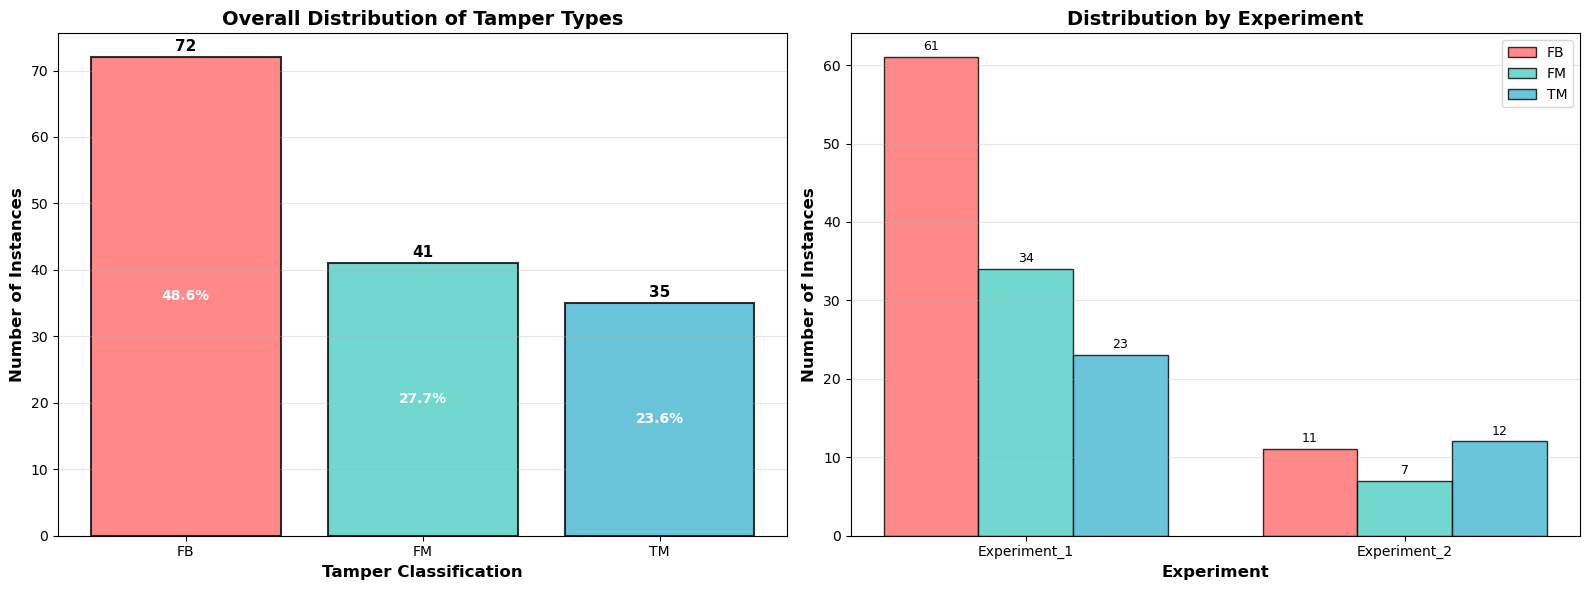


=== Combined Dataset Statistics ===
Total instances: 148

Overall class distribution:
  FB: 72 instances (48.6%)
  FM: 41 instances (27.7%)
  TM: 35 instances (23.6%)

Distribution by experiment:

Experiment_1 (118 total):
  FB: 61 (51.7%)
  FM: 34 (28.8%)
  TM: 23 (19.5%)

Experiment_2 (30 total):
  TM: 12 (40.0%)
  FB: 11 (36.7%)
  FM: 7 (23.3%)

2. EXPERIMENT COMPARISON


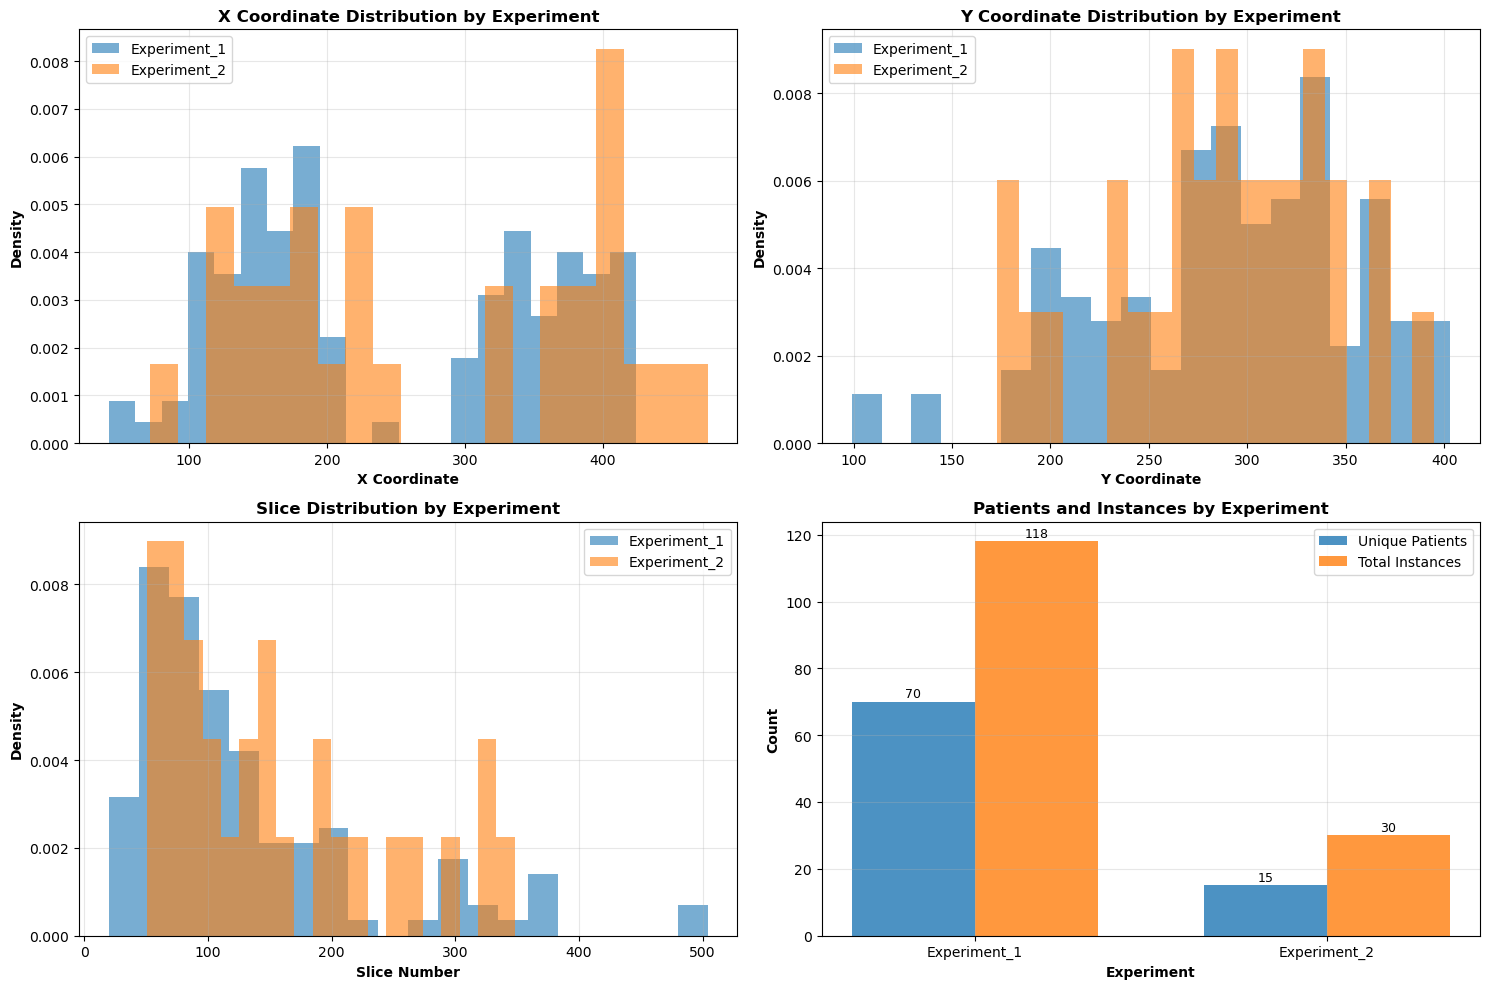


=== Experiment Comparison ===

Experiment_1:
  Total instances: 118
  Unique patients: 70
  Avg instances per patient: 1.69
  Spatial ranges:
    x: [42-424], mean=245.3±112.6
    y: [99-403], mean=288.9±65.2
    slice: [20-504], mean=131.0±98.7

Experiment_2:
  Total instances: 30
  Unique patients: 15
  Avg instances per patient: 2.00
  Spatial ranges:
    x: [72-476], mean=274.7±121.8
    y: [173-395], mean=287.5±56.2
    slice: [51-348], mean=153.3±89.4

3. COMBINED SPATIAL DISTRIBUTION


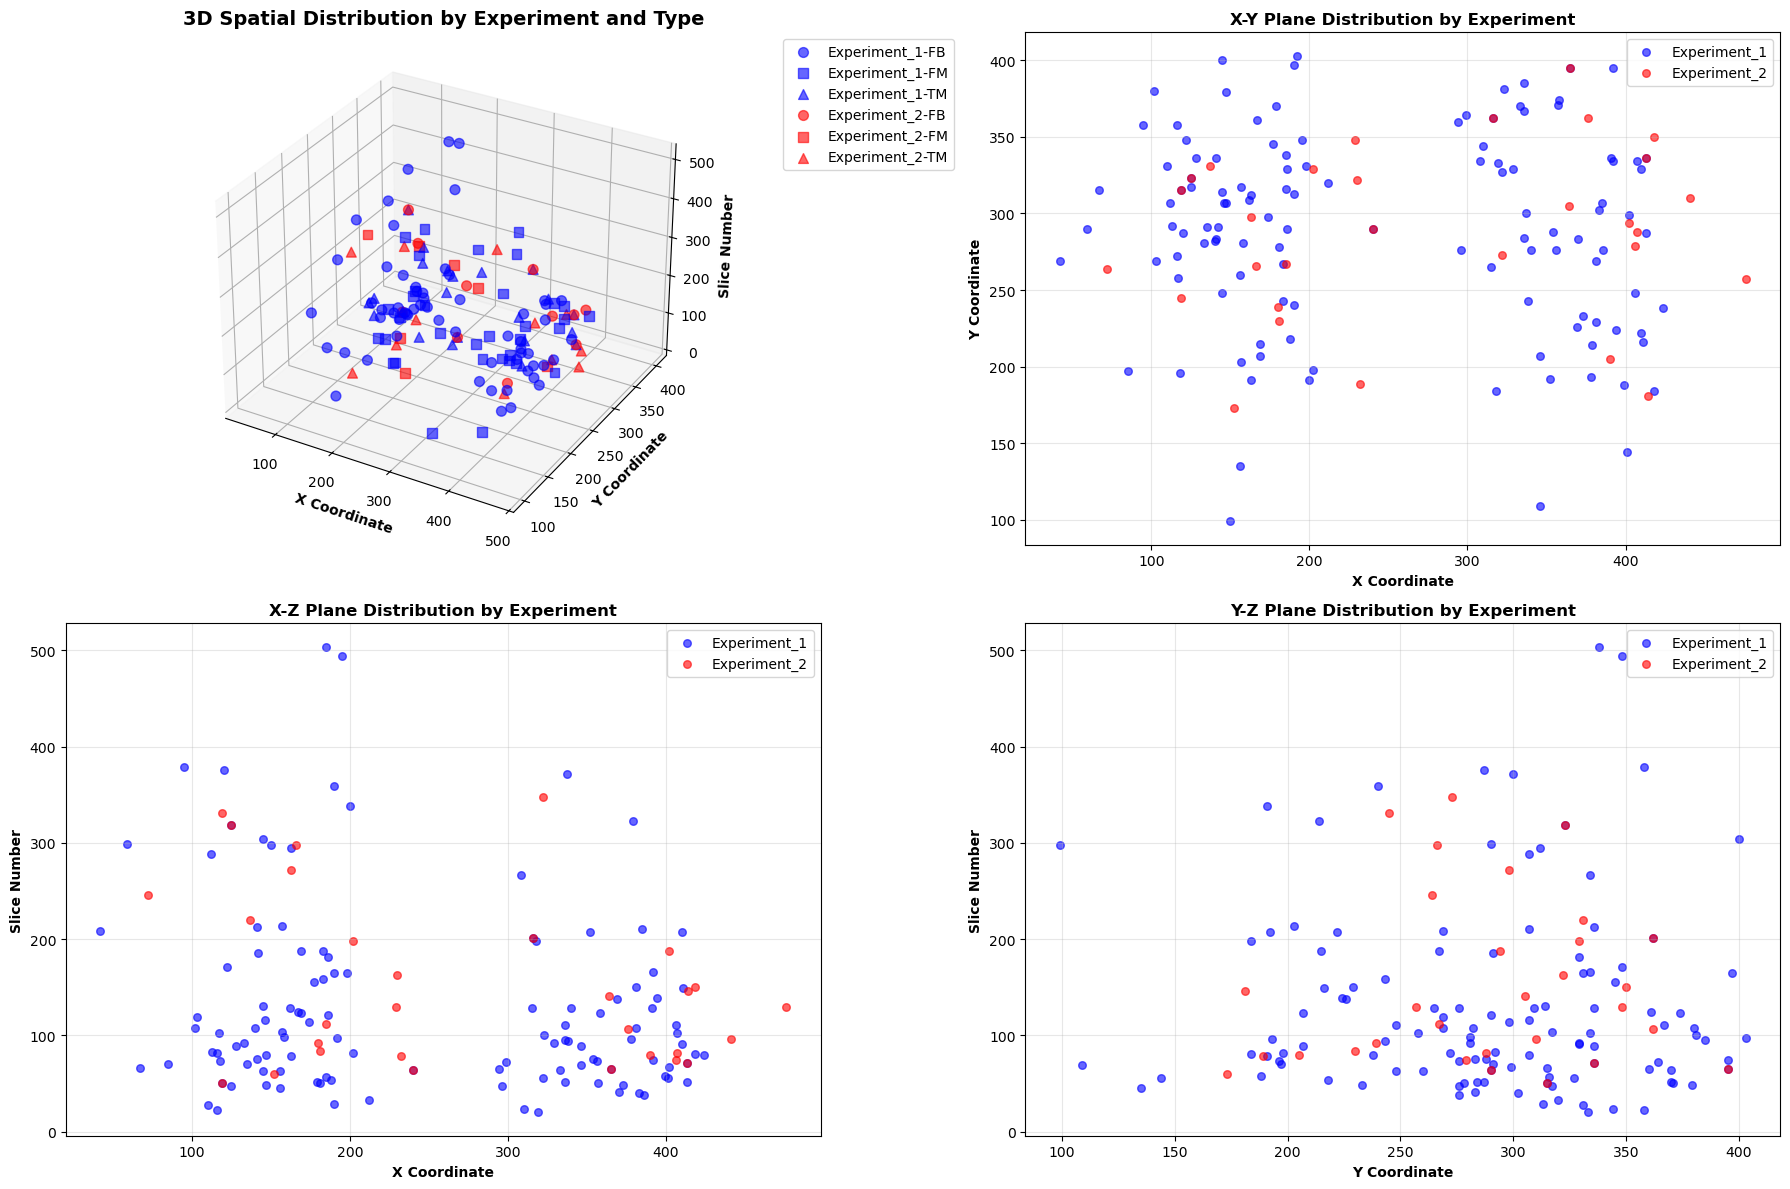


4. CORRELATION ANALYSIS


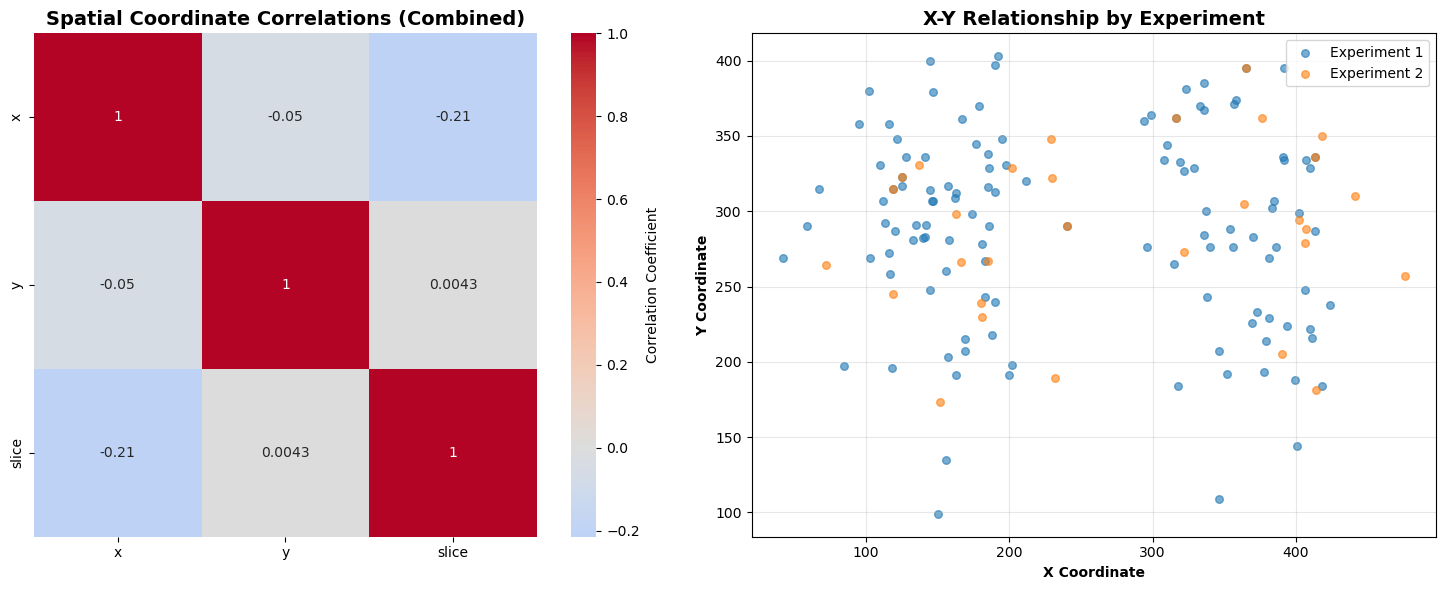


5. AUGMENTED SAMPLES VISUALIZATION


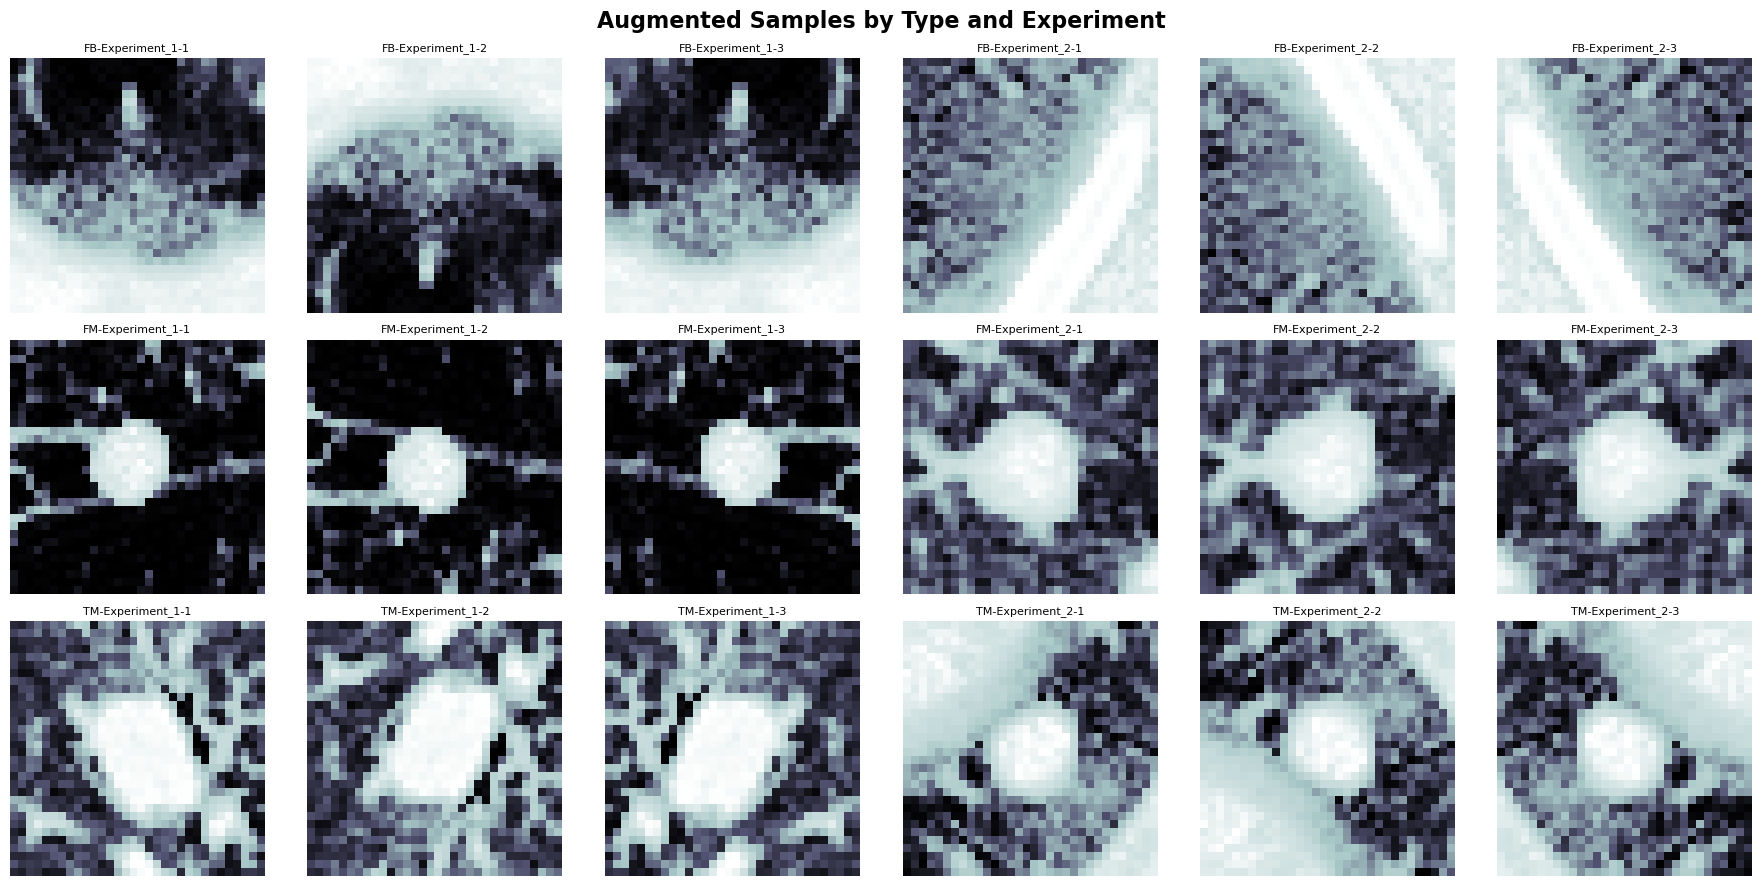


=== Augmentation Statistics ===
Total augmented samples: 1480
Samples per experiment:
  Experiment_1: 1180 samples
  Experiment_2: 300 samples

Augmentation factor per type:
  FB: 720 samples
  FM: 410 samples
  TM: 350 samples


In [7]:
if __name__ == "__main__":
    import os
    
    # Configuration
    base_path = os.path.expanduser("~/Downloads/deepfakes+medical+image+tamper+detection (1)/data/Tampered Scans/")
    
    experiments_config = [
        {
            'labels_csv': os.path.join(base_path, "labels_exp1.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 1 - Blind"),
            'experiment_name': 'Experiment_1'
        },
        {
            'labels_csv': os.path.join(base_path, "labels_exp2.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 2 - Open"),
            'experiment_name': 'Experiment_2'
        }
    ]
    
    output_dataset = "combined_tampered_scans_dataset.npy"
    
    # Run EDA
    df, label_encoder = run_combined_eda(experiments_config, output_dataset)

In [16]:
def create_split_eda_dataframe(experiments_config, dataset_base_path):
    """
    Create dataframe for EDA from split dataset
    """
    # Load original labels for reference
    combined_df = pd.DataFrame()
    
    for exp_config in experiments_config:
        df_exp = pd.read_csv(exp_config['labels_csv'])
        df_exp['experiment'] = exp_config['experiment_name']
        df_exp = df_exp[df_exp['type'].isin(['FB', 'FM', 'TM'])]
        df_exp = df_exp[~((df_exp['type'] == 'TB') & 
                         (df_exp['x'] == 0) & 
                         (df_exp['y'] == 0) & 
                         (df_exp['slice'] == 0))]
        combined_df = pd.concat([combined_df, df_exp], ignore_index=True)
    
    # Load metadata
    metadata_path = dataset_base_path.replace('.npy', '_metadata.json')
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Load split data
    split_info = {}
    for split in ['train', 'val', 'test']:
        split_path = dataset_base_path.replace('.npy', f'_{split}.npy')
        if os.path.exists(split_path):
            data = np.load(split_path)
            labels = np.load(split_path.replace('.npy', '_labels.npy'))
            experiments = np.load(split_path.replace('.npy', '_experiments.npy'))
            
            split_info[split] = {
                'data': data,
                'labels': labels,
                'experiments': experiments,
                'size': len(data)
            }
    
    return combined_df, split_info, metadata

def plot_split_statistics(combined_df, split_info, metadata):
    """Comprehensive visualization of split statistics"""
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Overall split sizes with augmentation info
    ax1 = plt.subplot(3, 3, 1)
    splits = list(split_info.keys())
    sizes = [split_info[s]['size'] for s in splits]
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    
    bars = ax1.bar(splits, sizes, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    
    # Add original sizes for comparison
    original_sizes = {
        'train': int(len(combined_df) * 0.6),
        'val': int(len(combined_df) * 0.2),
        'test': int(len(combined_df) * 0.2)
    }
    
    for i, (split, bar) in enumerate(zip(splits, bars)):
        # Show augmented size on bar
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                f'{sizes[i]}', ha='center', fontweight='bold', fontsize=12)
        # Show original size below
        if split == 'train':
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                    f'(orig: {original_sizes[split]})', ha='center', 
                    fontweight='bold', fontsize=10, color='white')
            # Show augmentation factor
            aug_factor = sizes[i] / original_sizes[split]
            ax1.text(bar.get_x() + bar.get_width()/2, -50, 
                    f'{aug_factor:.1f}x', ha='center', 
                    fontweight='bold', fontsize=11, color='red')
    
    ax1.set_title('Dataset Split Sizes\n(Training Set Augmented)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Samples', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(bottom=-100)
    
    # 2. Type distribution per split
    ax2 = plt.subplot(3, 3, 2)
    type_counts = {}
    for split in splits:
        unique_types, counts = np.unique(split_info[split]['labels'], return_counts=True)
        type_counts[split] = dict(zip(unique_types, counts))
    
    types = ['FB', 'FM', 'TM']
    x = np.arange(len(splits))
    width = 0.25
    type_colors = {'FB': '#FF6B6B', 'FM': '#4ECDC4', 'TM': '#45B7D1'}
    
    for i, ttype in enumerate(types):
        counts = [type_counts[split].get(ttype, 0) for split in splits]
        bars = ax2.bar(x + i*width, counts, width, label=ttype, 
                       color=type_colors[ttype], alpha=0.8, edgecolor='black')
        
        # Add value labels
        for j, (bar, count) in enumerate(zip(bars, counts)):
            if count > 0:
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                        str(count), ha='center', fontsize=9)
    
    ax2.set_xlabel('Split', fontsize=12)
    ax2.set_ylabel('Number of Samples', fontsize=12)
    ax2.set_title('Type Distribution per Split', fontsize=14, fontweight='bold')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(splits)
    ax2.legend(title='Type')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Experiment distribution per split
    ax3 = plt.subplot(3, 3, 3)
    exp_counts = {}
    for split in splits:
        unique_exps, counts = np.unique(split_info[split]['experiments'], return_counts=True)
        exp_counts[split] = dict(zip(unique_exps, counts))
    
    experiments = ['Experiment_1', 'Experiment_2']
    exp_colors = ['#8B5A3C', '#6B8E23']
    
    for i, exp in enumerate(experiments):
        counts = [exp_counts[split].get(exp, 0) for split in splits]
        bars = ax3.bar(x + i*width*1.5, counts, width*1.5, label=exp, 
                      color=exp_colors[i], alpha=0.8, edgecolor='black')
        
        for j, (bar, count) in enumerate(zip(bars, counts)):
            if count > 0:
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                        str(count), ha='center', fontsize=9)
    
    ax3.set_xlabel('Split', fontsize=12)
    ax3.set_ylabel('Number of Samples', fontsize=12)
    ax3.set_title('Experiment Distribution per Split', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width*0.75)
    ax3.set_xticklabels(splits)
    ax3.legend(title='Experiment')
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Class balance comparison
    ax4 = plt.subplot(3, 3, 4)
    
    # Calculate percentages for each split
    split_percentages = {}
    for split in splits:
        total = split_info[split]['size']
        type_pcts = {}
        for ttype in types:
            count = np.sum(split_info[split]['labels'] == ttype)
            type_pcts[ttype] = (count / total) * 100
        split_percentages[split] = type_pcts
    
    # Stacked bar chart
    bottom = np.zeros(len(splits))
    for ttype in types:
        pcts = [split_percentages[split][ttype] for split in splits]
        ax4.bar(splits, pcts, bottom=bottom, label=ttype, 
                color=type_colors[ttype], alpha=0.8, edgecolor='black')
        
        # Add percentage labels
        for i, (split, pct) in enumerate(zip(splits, pcts)):
            if pct > 5:  # Only show if > 5%
                ax4.text(i, bottom[i] + pct/2, f'{pct:.1f}%', 
                        ha='center', va='center', fontweight='bold', fontsize=10)
        bottom += pcts
    
    ax4.set_ylabel('Percentage', fontsize=12)
    ax4.set_title('Class Balance per Split (%)', fontsize=14, fontweight='bold')
    ax4.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.set_ylim(0, 100)
    
    # 5. Sample visualization from each split
    ax5 = plt.subplot(3, 3, 5)
    ax5.text(0.5, 0.5, 'Sample Visualizations\n(See separate figure)', 
             ha='center', va='center', fontsize=14,
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    ax5.axis('off')
    
    # 6. Augmentation statistics
    ax6 = plt.subplot(3, 3, 6)
    
    if 'train' in split_info:
        # Original vs augmented for each type in training
        train_labels = split_info['train']['labels']
        unique_types, aug_counts = np.unique(train_labels, return_counts=True)
        
        # Estimate original counts
        orig_train_size = len(combined_df) * 0.6
        type_dist_original = combined_df['type'].value_counts()
        total_original = len(combined_df)
        
        x = np.arange(len(unique_types))
        width = 0.35
        
        orig_counts = []
        for ttype in unique_types:
            if ttype in type_dist_original:
                orig_count = (type_dist_original[ttype] / total_original) * orig_train_size
                orig_counts.append(int(orig_count))
            else:
                orig_counts.append(0)
        
        bars1 = ax6.bar(x - width/2, orig_counts, width, label='Original', 
                        color='lightblue', alpha=0.8, edgecolor='black')
        bars2 = ax6.bar(x + width/2, aug_counts, width, label='Augmented', 
                        color='darkblue', alpha=0.8, edgecolor='black')
        
        # Add value labels and augmentation factors
        for i, (orig, aug) in enumerate(zip(orig_counts, aug_counts)):
            ax6.text(i - width/2, orig + 5, str(orig), ha='center', fontsize=9)
            ax6.text(i + width/2, aug + 5, str(aug), ha='center', fontsize=9)
            if orig > 0:
                factor = aug / orig
                ax6.text(i, -20, f'{factor:.1f}x', ha='center', 
                        fontweight='bold', fontsize=10, color='red')
        
        ax6.set_xlabel('Type', fontsize=12)
        ax6.set_ylabel('Number of Samples', fontsize=12)
        ax6.set_title('Training Set: Original vs Augmented', fontsize=14, fontweight='bold')
        ax6.set_xticks(x)
        ax6.set_xticklabels(unique_types)
        ax6.legend()
        ax6.grid(axis='y', alpha=0.3)
        ax6.set_ylim(bottom=-50)
    
    # 7. Split proportions pie chart
    ax7 = plt.subplot(3, 3, 7)
    total_samples = sum(sizes)
    percentages = [(s/total_samples)*100 for s in sizes]
    
    wedges, texts, autotexts = ax7.pie(percentages, labels=splits, colors=colors, 
                                        autopct='%1.1f%%', startangle=90,
                                        explode=(0.05, 0, 0))
    
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(11)
        autotext.set_fontweight('bold')
    
    ax7.set_title('Overall Split Proportions\n(After Augmentation)', fontsize=14, fontweight='bold')
    
    # 8. Summary statistics table
    ax8 = plt.subplot(3, 3, 8)
    ax8.axis('tight')
    ax8.axis('off')
    
    # Create summary table
    summary_data = []
    for split in splits:
        split_data = split_info[split]
        row = [
            split.capitalize(),
            split_data['size'],
            f"{(split_data['size']/total_samples)*100:.1f}%",
            'Yes' if split == 'train' else 'No'
        ]
        summary_data.append(row)
    
    table = ax8.table(cellText=summary_data,
                     colLabels=['Split', 'Samples', '% of Total', 'Augmented'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.25, 0.25, 0.25, 0.25])
    
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)
    
    # Style the table
    for i in range(len(summary_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#40466e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f1f1f2' if i % 2 == 0 else 'white')
                if j == 3 and summary_data[i-1][j] == 'Yes':  # Augmented column
                    cell.set_text_props(weight='bold', color='green')
    
    ax8.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)
    
    # 9. Data quality metrics
    ax9 = plt.subplot(3, 3, 9)
    
    metrics_text = f"""Data Quality Metrics:
    
Original Dataset:
  • Total samples: {len(combined_df)}
  • Unique patients: {combined_df['uuid'].nunique()}
  • Experiments: {len(combined_df['experiment'].unique())}

After Processing:
  • Total samples: {total_samples}
  • Train augmentation: {sizes[0]/original_sizes['train']:.1f}x
  • Validation size: {sizes[1]} (preserved)
  • Test size: {sizes[2]} (preserved)

Split Strategy:
  • Method: Stratified by type & experiment
  • Random state: {metadata.get('random_state', 'N/A')}
  • No data leakage guaranteed"""
    
    ax9.text(0.05, 0.95, metrics_text, transform=ax9.transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    ax9.axis('off')
    ax9.set_title('Processing Summary', fontsize=14, fontweight='bold')
    
    plt.suptitle('Split Dataset Analysis - Medical Image Tamper Detection', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

def visualize_split_samples(split_info, num_samples=3):
    """Visualize samples from each split"""
    splits = list(split_info.keys())
    types = ['FB', 'FM', 'TM']
    
    fig, axes = plt.subplots(len(splits), len(types) * num_samples, 
                            figsize=(len(types) * num_samples * 3, len(splits) * 3))
    
    if len(splits) == 1:
        axes = axes.reshape(1, -1)
    
    for i, split in enumerate(splits):
        split_data = split_info[split]
        col_idx = 0
        
        for ttype in types:
            # Find samples of this type
            type_mask = split_data['labels'] == ttype
            type_indices = np.where(type_mask)[0]
            
            if len(type_indices) > 0:
                # Select random samples
                selected_indices = np.random.choice(type_indices, 
                                                  min(num_samples, len(type_indices)), 
                                                  replace=False)
                
                for sample_idx in selected_indices:
                    if col_idx < axes.shape[1]:
                        sample = split_data['data'][sample_idx]
                        middle_slice = sample.shape[0] // 2
                        
                        axes[i, col_idx].imshow(sample[middle_slice, :, :], cmap='bone')
                        axes[i, col_idx].set_title(f'{split}-{ttype}', fontsize=10)
                        axes[i, col_idx].axis('off')
                        col_idx += 1
            else:
                # Fill empty spots
                for _ in range(num_samples):
                    if col_idx < axes.shape[1]:
                        axes[i, col_idx].text(0.5, 0.5, f'No {ttype}', 
                                            ha='center', va='center',
                                            transform=axes[i, col_idx].transAxes)
                        axes[i, col_idx].axis('off')
                        col_idx += 1
    
    plt.suptitle('Sample Visualizations from Each Split', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_detailed_statistics(combined_df, split_info, metadata):
    """Print detailed statistics about the splits"""
    print("="*80)
    print("DETAILED SPLIT STATISTICS - MEDICAL IMAGE TAMPER DETECTION")
    print("="*80)
    
    print(f"\nOriginal Dataset:")
    print(f"  Total samples: {len(combined_df)}")
    print(f"  Unique patients: {combined_df['uuid'].nunique()}")
    print(f"  Type distribution:")
    for ttype, count in combined_df['type'].value_counts().items():
        print(f"    {ttype}: {count} ({count/len(combined_df)*100:.1f}%)")
    
    print(f"\nSplit Configuration:")
    print(f"  Train: {metadata['split_ratios']['train']*100:.0f}%")
    print(f"  Val: {metadata['split_ratios']['val']*100:.0f}%")
    print(f"  Test: {metadata['split_ratios']['test']*100:.0f}%")
    print(f"  Random state: {metadata.get('random_state', 'N/A')}")
    
    print(f"\nProcessed Dataset:")
    total_processed = sum(split_info[s]['size'] for s in split_info)
    print(f"  Total samples (after augmentation): {total_processed}")
    
    for split in ['train', 'val', 'test']:
        if split in split_info:
            print(f"\n{split.upper()} Set:")
            split_data = split_info[split]
            print(f"  Size: {split_data['size']}")
            
            if split == 'train':
                expected_original = int(len(combined_df) * metadata['split_ratios']['train'])
                aug_factor = split_data['size'] / expected_original
                print(f"  Augmentation factor: {aug_factor:.1f}x")
            
            print(f"  Type distribution:")
            unique_types, counts = np.unique(split_data['labels'], return_counts=True)
            for ttype, count in zip(unique_types, counts):
                print(f"    {ttype}: {count} ({count/split_data['size']*100:.1f}%)")
            
            print(f"  Experiment distribution:")
            unique_exps, counts = np.unique(split_data['experiments'], return_counts=True)
            for exp, count in zip(unique_exps, counts):
                print(f"    {exp}: {count} ({count/split_data['size']*100:.1f}%)")
    
    print("\n" + "="*80)

def run_split_eda(experiments_config, dataset_base_path):
    """Run complete EDA for split dataset"""
    print("\n=== SPLIT DATASET EDA - MEDICAL IMAGE TAMPER DETECTION ===\n")
    
    # Load data
    combined_df, split_info, metadata = create_split_eda_dataframe(
        experiments_config, dataset_base_path
    )
    
    # Run visualizations
    plot_split_statistics(combined_df, split_info, metadata)
    visualize_split_samples(split_info, num_samples=3)
    
    # Print statistics
    print_detailed_statistics(combined_df, split_info, metadata)
    
    return combined_df, split_info, metadata


=== SPLIT DATASET EDA - MEDICAL IMAGE TAMPER DETECTION ===



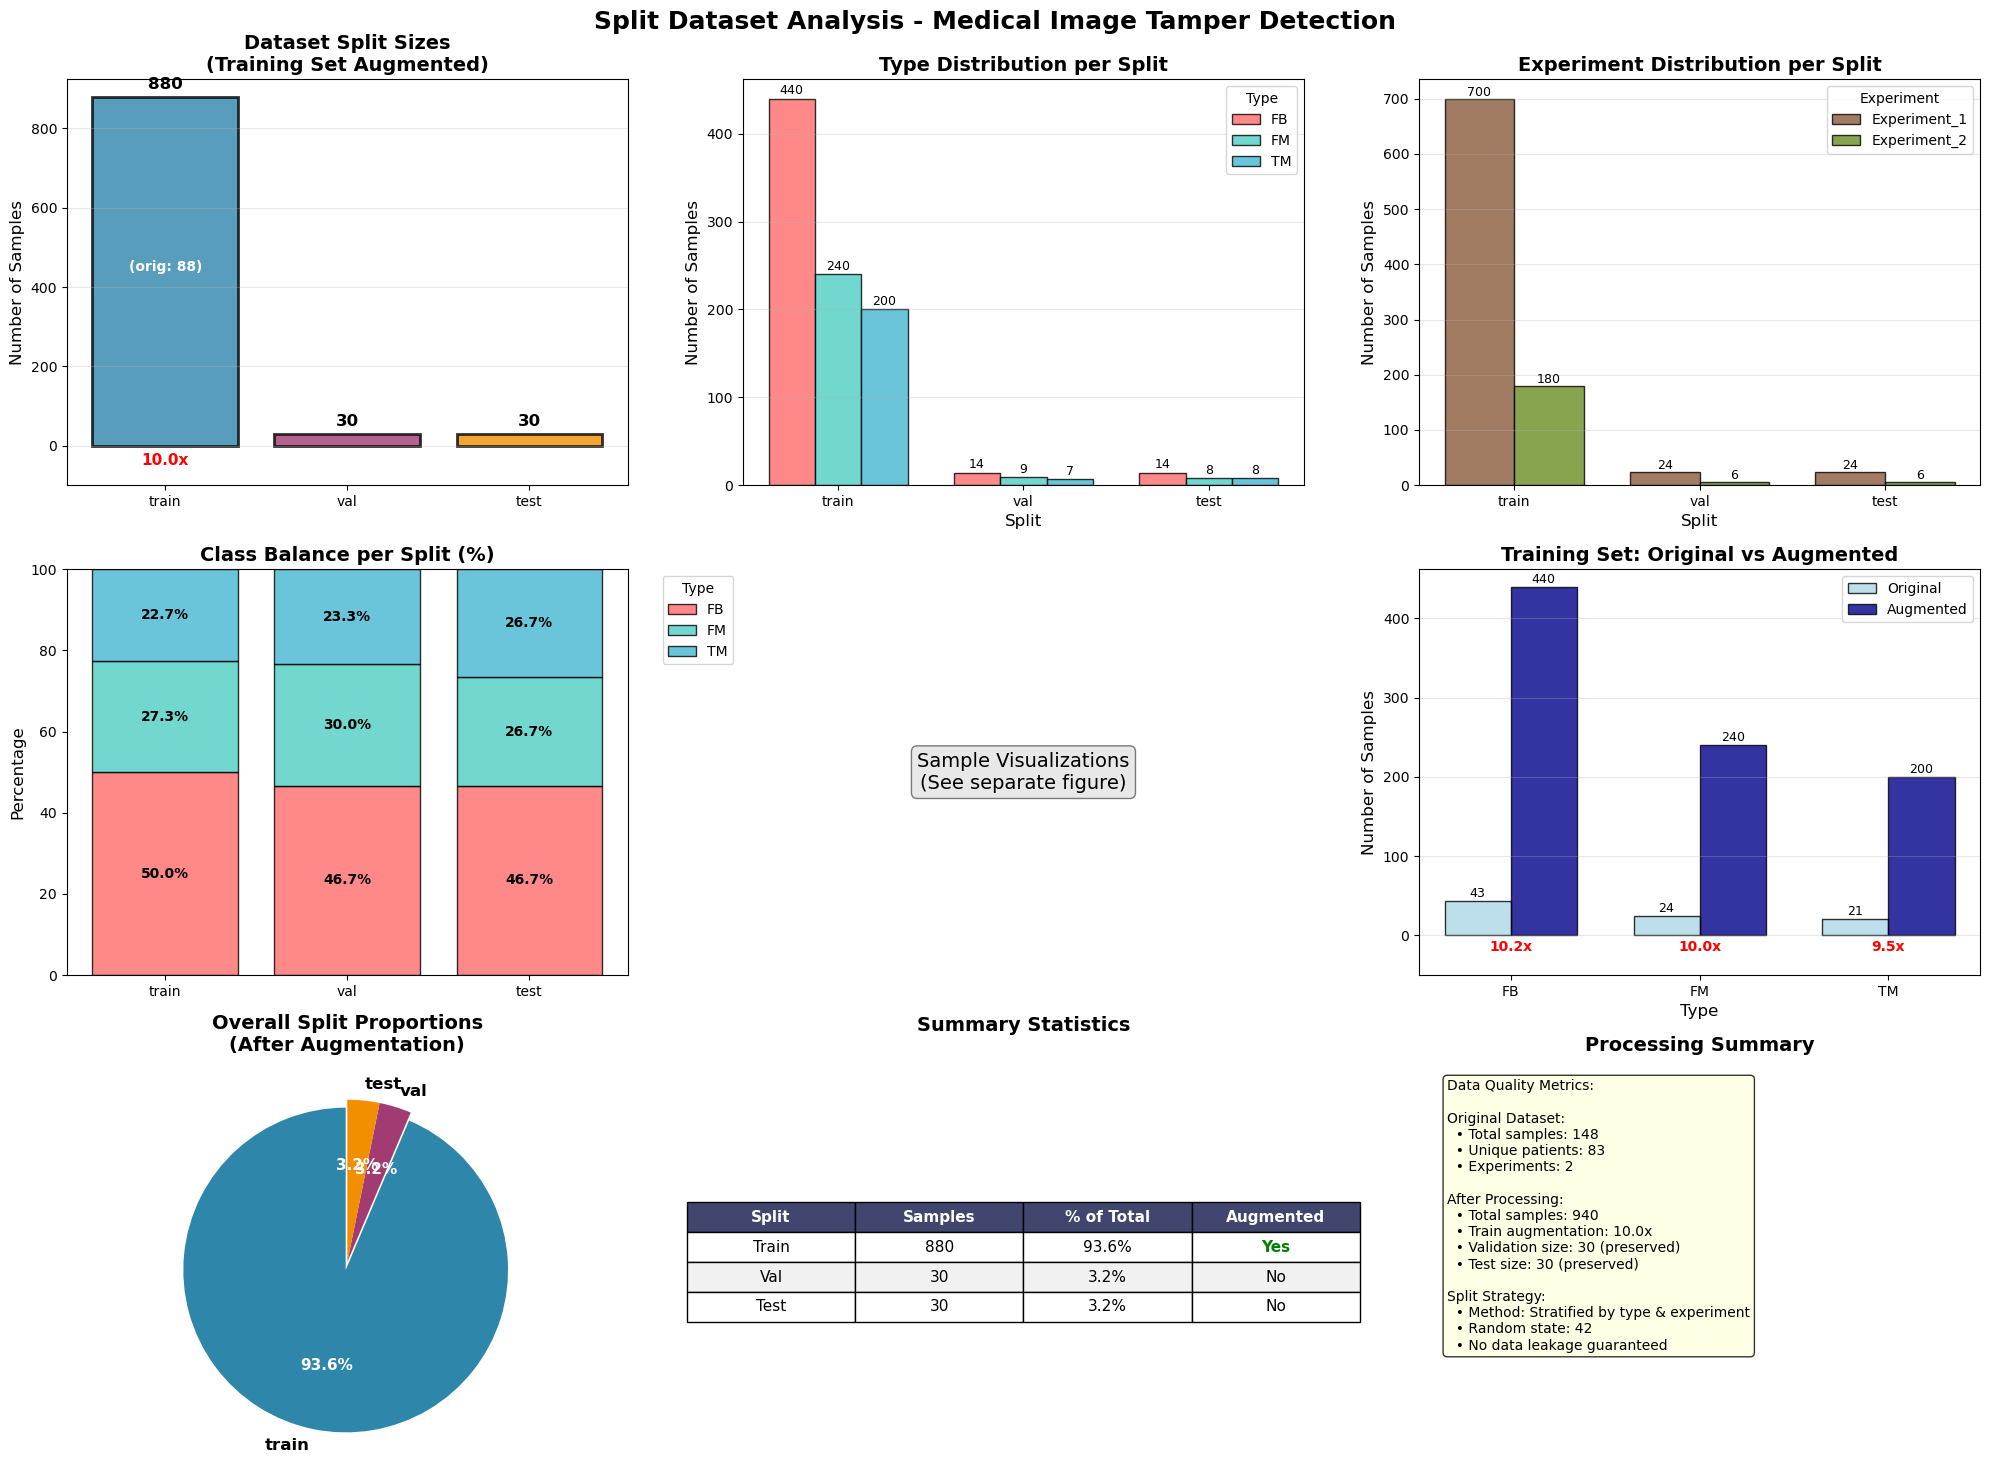

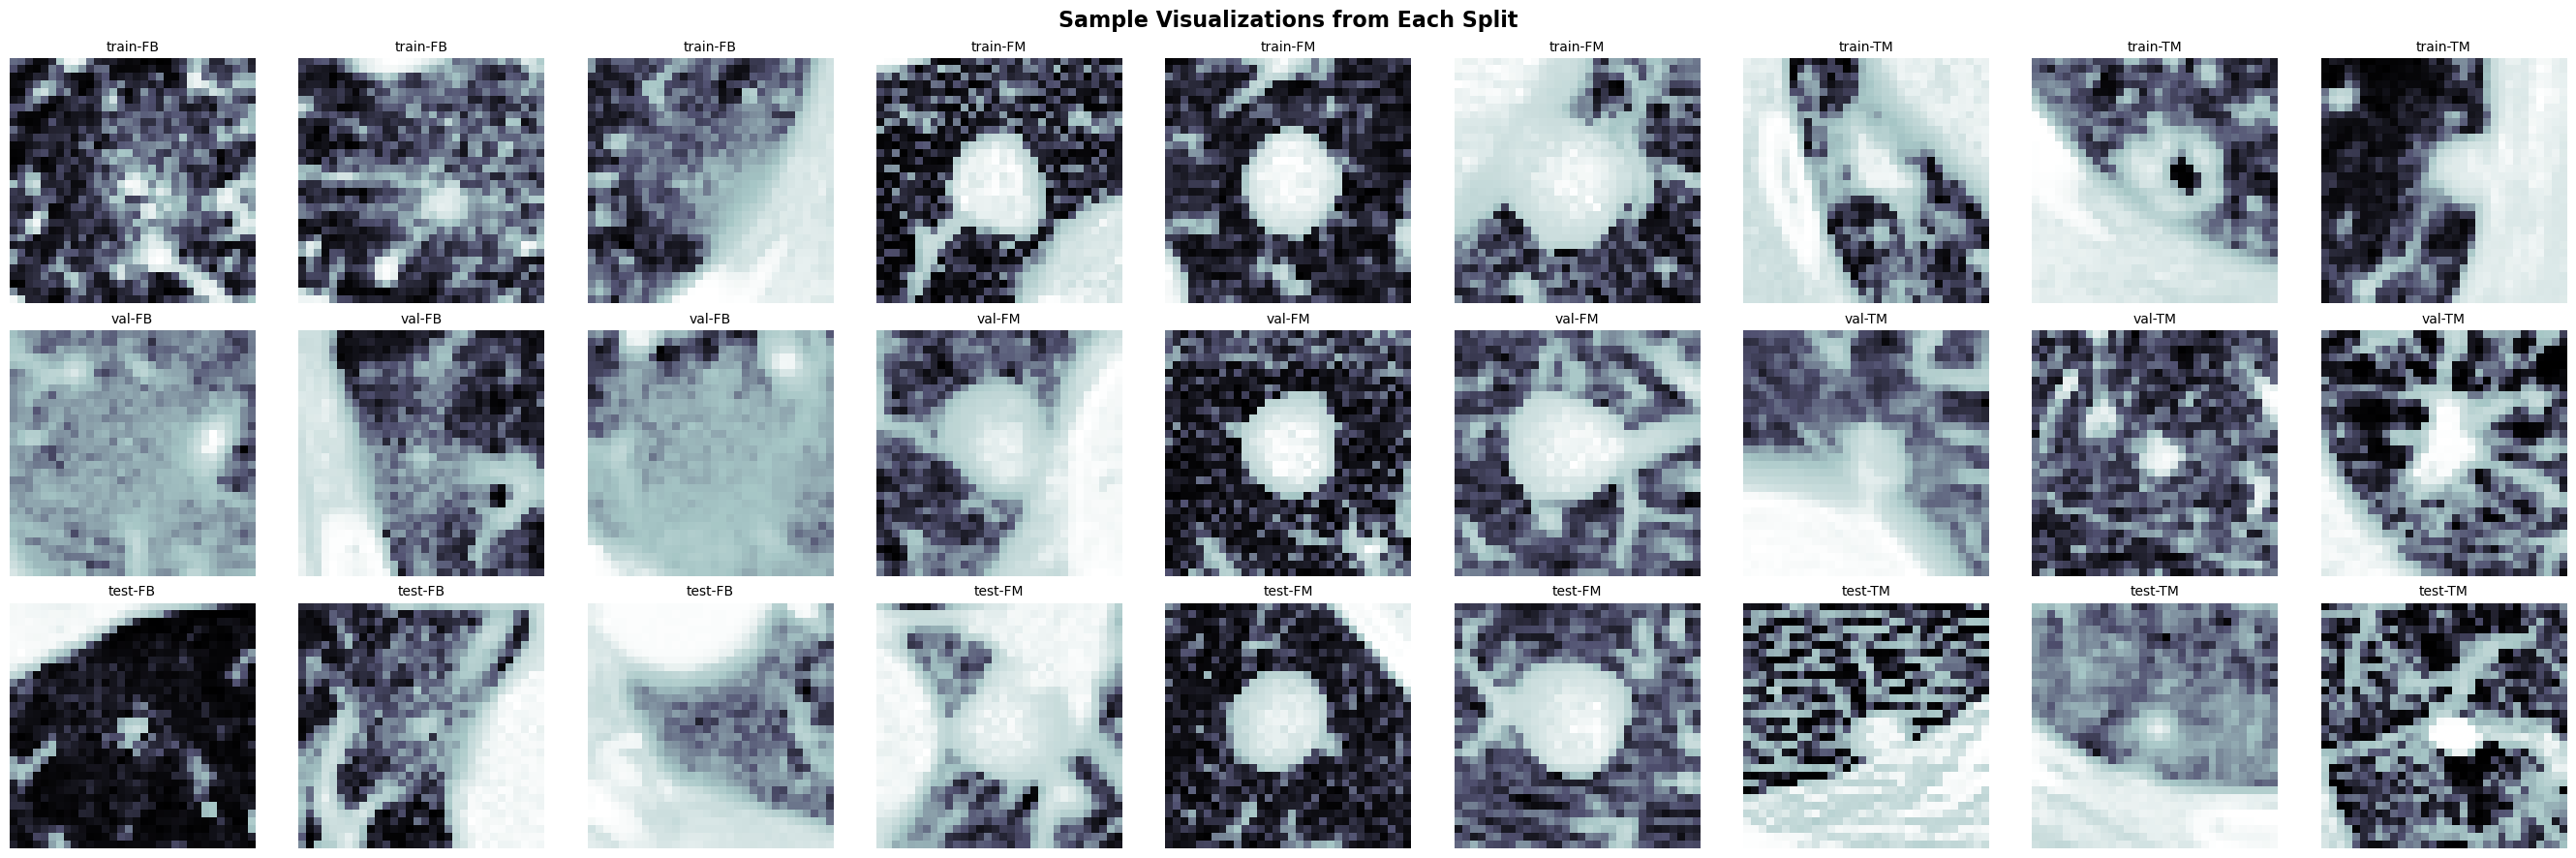

DETAILED SPLIT STATISTICS - MEDICAL IMAGE TAMPER DETECTION

Original Dataset:
  Total samples: 148
  Unique patients: 83
  Type distribution:
    FB: 72 (48.6%)
    FM: 41 (27.7%)
    TM: 35 (23.6%)

Split Configuration:
  Train: 60%
  Val: 20%
  Test: 20%
  Random state: 42

Processed Dataset:
  Total samples (after augmentation): 940

TRAIN Set:
  Size: 880
  Augmentation factor: 10.0x
  Type distribution:
    FB: 440 (50.0%)
    FM: 240 (27.3%)
    TM: 200 (22.7%)
  Experiment distribution:
    Experiment_1: 700 (79.5%)
    Experiment_2: 180 (20.5%)

VAL Set:
  Size: 30
  Type distribution:
    FB: 14 (46.7%)
    FM: 9 (30.0%)
    TM: 7 (23.3%)
  Experiment distribution:
    Experiment_1: 24 (80.0%)
    Experiment_2: 6 (20.0%)

TEST Set:
  Size: 30
  Type distribution:
    FB: 14 (46.7%)
    FM: 8 (26.7%)
    TM: 8 (26.7%)
  Experiment distribution:
    Experiment_1: 24 (80.0%)
    Experiment_2: 6 (20.0%)



In [18]:
if __name__ == "__main__":
    # Configuration
    base_path = os.path.expanduser("~/Downloads/deepfakes+medical+image+tamper+detection (1)/data/Tampered Scans/")
    
    experiments_config = [
        {
            'labels_csv': os.path.join(base_path, "labels_exp1.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 1 - Blind"),
            'experiment_name': 'Experiment_1'
        },
        {
            'labels_csv': os.path.join(base_path, "labels_exp2.csv"),
            'dicom_dir': os.path.join(base_path, "Experiment 2 - Open"),
            'experiment_name': 'Experiment_2'
        }
    ]
    
    output_dataset = "combined_tampered_scans_dataset.npy"
    
    # Run EDA for split dataset
    combined_df, split_info, metadata = run_split_eda(experiments_config, output_dataset)